# Import libraries

In [32]:
import os
import cv2
import time
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt

### Other dependencies ###
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

### Tensorflow dependencies ###
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

### Some constants ###
input_dim = 12 # 48
# weights_dir = 'road_signs_1'
weights_dir = 'road_signs_2'
pnet_tensorboard_logdir = '../pnet_logs'
rnet_tensorboard_logdir = '../rnet_logs'
onet_tensorboard_logdir = '../onet_logs'

pnet_weights = f'../weights/{weights_dir}/pnet.weights.hdf5'
rnet_weights = f'../weights/{weights_dir}/rnet.weights.hdf5'
onet_weights = f'../weights/{weights_dir}/onet.weights.hdf5'

if(not os.path.exists(f'../weights/{weights_dir}')):
    print('[INFO] Created weight directory ...')
    os.mkdir(f'../weights/{weights_dir}')
    
if(os.path.exists(pnet_tensorboard_logdir)):
    print('[INFO] Clearing P-Net log directory ... ')
    shutil.rmtree(pnet_tensorboard_logdir)

if(os.path.exists(rnet_tensorboard_logdir)):
    print('[INFO] Clearing R-Net log directory ... ')
    shutil.rmtree(rnet_tensorboard_logdir)

if(os.path.exists(onet_tensorboard_logdir)):
    print('[INFO] Clearing O-Net log directory ... ')
    shutil.rmtree(onet_tensorboard_logdir)
    
epochs = 500
batch_size = 16
pnet_tensorboard = TensorBoard(log_dir=pnet_tensorboard_logdir)
pnet_checkpoint = ModelCheckpoint(pnet_weights, save_weights_only=True)
pnet_callbacks = [pnet_tensorboard, pnet_checkpoint]

rnet_tensorboard = TensorBoard(log_dir=rnet_tensorboard_logdir)
rnet_checkpoint = ModelCheckpoint(rnet_weights, save_weights_only=True)
rnet_callbacks = [rnet_tensorboard, rnet_checkpoint]

onet_tensorboard = TensorBoard(log_dir=onet_tensorboard_logdir)
onet_checkpoint = ModelCheckpoint(onet_weights, save_weights_only=True)
onet_early_stop1 = EarlyStopping(monitor='val_probability_loss', patience=15, verbose=1)
onet_early_stop2 = EarlyStopping(monitor='val_bbox_regression_loss', patience=15, verbose=1)
onet_callbacks = [onet_tensorboard, onet_checkpoint]

train_dir = "/home/minhhieu/Desktop/Hieu/datasets/RoadSignDetection/images"
test_dir = "/home/minhhieu/Desktop/Hieu/datasets/GTSDB/TestIJCNN2013/TestIJCNN2013Download"

[INFO] Created weight directory ...
[INFO] Clearing P-Net log directory ... 
[INFO] Clearing R-Net log directory ... 


# Load and explore dataset

In [33]:
def load_raw_dataset(dataset_dir, gt_file, delimiter=';', max_n_samples=3000):
    '''
        This function will take in a dataset directory with ppm images (according to the DTSDB dataset)
        then it will return a list where each element is a list of 3 items. First item is the image, the
        second item is the bounding box and the last is the class ID.
        
        Params :
            @dataset_dir : Dataset directory.
            @gt_file : The file that consists of ground truth annotation in the format
            <img_pth>;<left>;<top>;<right>;<bottom>;<class_idx>.
            @delimiter : The separator of each item in each line of the ground truth file
            
        Returns :
            raw_dataset : list of elements [<cv2_img>, <gt_bbox>, <class_idx>]
    '''
    gt_abs_path = os.path.join(dataset_dir, gt_file)
    class_ids = {}
    lines = open(gt_abs_path, 'r').readlines()
    
    print('[INFO] From images to ground truth ... ')
    images_to_gt = [[x.strip().split(delimiter)[0],   # Image path
                     x.strip().split(delimiter)[1:5], # Bbox regression ground truth
                     x.strip().split(delimiter)[5]]   # The class index
                    for x in lines]
    
    print('[INFO] Converting to raw dataset ... ')
    raw_dataset = [[cv2.cvtColor(cv2.imread(os.path.join(dataset_dir, x[0])), cv2.COLOR_BGR2RGB),
                    np.array(x[1]).astype('int'),
                    x[2]] 
                  for x in images_to_gt[:max_n_samples]]
    
    print(f'[INFO] {len(raw_dataset)} samples loaded ... ')
    
    return raw_dataset
    
# raw_dataset = load_raw_dataset(train_dir, 'gt.txt')

# ### Visualize sample data ###
# img = raw_dataset[1][0].copy()
# bbox = raw_dataset[1][1]
# x1, y1, x2, y2 = bbox
# img = cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 2)
# plt.imshow(img)
# plt.show()

### Generating negative samples (samples without traffic signs)

In [34]:
def generate_neg_samples(raw_dataset, frame_per_img=4, crop_size=(48, 48)):
    '''
        This function will generate croppings of fixed size without any traffic sign
        and return those croppings with dummy bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @crop_size : The fixed cropping size
            
        Return:
            neg_samples : A list in format [<crop_img>,<dummy_bbox>,0]
    '''
    neg_samples = []
    for img, bbox, class_id in raw_dataset:
        for i in range(frame_per_img):
            height, width = img.shape[:2]
            x1, y1, x2, y2 = bbox
            range_x = ((0, max(x1 - crop_size[0], 0)), (min(x2 + crop_size[0], width), width))
            range_y = ((0, max(y1 - crop_size[1], 0)), (min(y2 + crop_size[1], height), height))

            ### Generate a random x,y coordinates ###
            x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                               random.randint(range_x[1][0], range_x[1][1])])
            y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                               random.randint(range_y[1][0], range_y[1][1])])

            # regenerate if cropping does not satisfy the size requirements
            while(width - x < crop_size[0] or height - y < crop_size[1]):
                x = random.choice([random.randint(range_x[0][0], range_x[0][1]), 
                               random.randint(range_x[1][0], range_x[1][1])])
                y = random.choice([random.randint(range_y[0][0], range_y[0][1]), 
                               random.randint(range_y[1][0], range_y[1][1])])

            crop = img[y:y+crop_size[1], x:x+crop_size[0]]
            neg_samples.append([crop, np.array([0,0,0,0]), 0])
        
    print(f'[INFO] {len(neg_samples)} negative samples generated ... ')
    return np.array(neg_samples)

# neg_samples = generate_neg_samples(raw_dataset, crop_size=(input_dim,input_dim))
# plt.imshow(neg_samples[1][0].copy())
# plt.show()

### Generate positive samples (samles with traffic signs)

In [35]:
def generate_pos_samples(raw_dataset, pad_range=(10, 100), frame_per_img=4, img_size=48):
    '''
        This function will generate croppings with traffic signs
        and return those croppings with bbox ground truth
        
        Params:
            @raw_dataset : The raw dataset formated similarly above
            @pad_range : The pad range around the ground truth bounding box
            
        Return:
            pos_samples : A list in format [<crop_img>,<bbox>,1]
    '''
    pos_samples = []
    for img, bbox, class_id in raw_dataset:
        for i in range(frame_per_img):
            height, width = img.shape[:2]
            x1, y1, x2, y2 = bbox
            pad_x1 = min(x1, random.randint(pad_range[0], pad_range[1]))
            pad_x2 = min(width - x2, random.randint(pad_range[0], pad_range[1]))
            pad_y1 = min(y1, random.randint(pad_range[0], pad_range[1]))
            pad_y2 = min(height - y2, random.randint(pad_range[0], pad_range[1]))

            crop = img[y1 - pad_y1:y2 + pad_y2, x1 - pad_x1:x2 + pad_x2]
            h, w = crop.shape[:2]

            gt = np.array([pad_x1, pad_y1, pad_x1 + x2 - x1, pad_y1 + y2 - y1])
            gt[2] = gt[2] - gt[0] # Calculates width
            gt[3] = gt[3] - gt[1] # Calculates height
            gt = np.multiply(gt, np.array([1/w, 1/h, 1/w, 1/h])).astype('float32')

            crop = cv2.resize(crop, (img_size, img_size))
            pos_samples.append([crop, gt, class_id])
        
    print(f'[INFO] {len(pos_samples)} positive samples generated ... ')
    return np.array(pos_samples)

# pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 15), img_size=input_dim)

# img, gt, label = pos_samples[6]
# img = img.copy()
# h, w = img.shape[:2]
# x1, y1, w, h = np.multiply(gt, np.array([w,h,w,h])).astype('int')

# img = cv2.rectangle(img, (x1, y1), (x1+w, y1+h), 2)
# plt.imshow(img)
# plt.show()

### Combine negative and positive samples to form training dataset

In [36]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, frame_per_img=4, crop_size=(input_dim,input_dim))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(5, 15), frame_per_img=4, img_size=input_dim)
pos_samples[:, 2] = 1.0
# pos_samples[:,2] = LabelEncoder().fit_transform(pos_samples[:, 2])
# pos_samples[:,2] += 1

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 
[INFO] 4976 negative samples generated ... 
[INFO] 4976 positive samples generated ... 


# Implement P-Net architecture

In [37]:
def conv_block(in_filters, out_filters, kernel_size=3, batch_norm=False):
    inputs = Input(shape=(None, None, in_filters))
    p_layer = Conv2D(out_filters, kernel_size=kernel_size, strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(inputs)
    if(batch_norm) : p_layer = BatchNormalization()(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
        
    p_layer = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")(p_layer)
    
    block = Model(inputs = inputs, outputs=p_layer)
    return block

def build_pnet_model(input_shape=None, batch_norm=True, dropout=False, n_classes=2, activation='relu'):
    if(input_shape is not None):
        if(input_shape not in [12, 24, 48, 112, 224]):
            raise Exception('Input shape must be in 12, 24, 48')
    
    inputs = Input(shape=(None, None, 3))
    p_layer = conv_block(3, 10, kernel_size=3, batch_norm=batch_norm)(inputs)
    
    if(input_shape is not None):
        if(input_shape >= 24):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)
    
    if(input_shape is not None):
        if(input_shape >= 48):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)
            
    if(input_shape is not None):
        if(input_shape >= 112):
            p_layer = conv_block(10, 10, kernel_size=3, batch_norm=batch_norm)(p_layer)

    p_layer = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
        
    p_layer = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="valid", kernel_regularizer=l2(2e-4))(p_layer)
    p_layer = PReLU(shared_axes=[1, 2])(p_layer)
    if(dropout) : p_layer = Dropout(0.5)(p_layer)

    p_layer_out1 = Conv2D(n_classes, kernel_size=(1, 1), strides=(2, 2))(p_layer)
    p_layer_out1 = Softmax(axis=3, name='probability')(p_layer_out1)
    p_layer_out2 = Conv2D(4, kernel_size=(1, 1), strides=(2, 2), activation='sigmoid', name='bbox_regression')(p_layer)

    p_net = Model(inputs, [p_layer_out1, p_layer_out2], name='P-Net')

    return p_net


### GIoU formula ###
def GIoU(bboxes_1, bboxes_2, regularization=False):
    # 1. calulate intersection over union
    area_1 = (bboxes_1[..., 2] - bboxes_1[..., 0]) * (bboxes_1[..., 3] - bboxes_1[..., 1])
    area_2 = (bboxes_2[..., 2] - bboxes_2[..., 0]) * (bboxes_2[..., 3] - bboxes_2[..., 1])
    
    intersection_wh = tf.minimum(bboxes_1[:, :, 2:], bboxes_2[:, :, 2:]) - tf.maximum(bboxes_1[:, :, :2], bboxes_2[:, :, :2])
    intersection_wh = tf.maximum(intersection_wh, 0)
    
    intersection = intersection_wh[..., 0] * intersection_wh[..., 1]
    union = (area_1 + area_2) - intersection
    
    ious = intersection / tf.maximum(union, 1e-10)

    # 2. (C - (A U B))/C
    C_wh = tf.maximum(bboxes_1[..., 2:], bboxes_2[..., 2:]) - tf.minimum(bboxes_1[..., :2], bboxes_2[..., :2])
    C_wh = tf.maximum(C_wh, 0.0)
    C = C_wh[..., 0] * C_wh[..., 1]
    
    # 3. Additional regularization - to preserve aspect ratio
    lambda_ = 2e-4
    w_reg = lambda_ * K.binary_crossentropy(bboxes_1[..., 2], bboxes_2[...,2])
    h_reg = lambda_ * K.binary_crossentropy(bboxes_1[..., 3], bboxes_2[...,3])
    
    giou = ious - (C - union) / tf.maximum(C, 1e-10)
    if(regularization):
        giou += 0.5 * (w_reg + h_reg)
        
    return giou 

n_classes = 2# train_labels.shape[3]
pnet = build_pnet_model(input_shape=input_dim, batch_norm=True, dropout=True,
                        n_classes=n_classes)
print(pnet(tf.random.normal((1,input_dim,input_dim,3)))[1].shape)
print(pnet.summary())

(1, 1, 1, 4)
Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
functional_19 (Functional)      (None, None, None, 1 330         input_15[0][0]                   
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, None, None, 1 1456        functional_19[0][0]              
__________________________________________________________________________________________________
p_re_lu_20 (PReLU)              (None, None, None, 1 16          conv2d_25[0][0]                  
_________________________________________________________________________________

# Start training P-Net

In [38]:
losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() # MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

if(os.path.exists(pnet_weights)):
    print('[INFO] Loading P-Net pretrained weights ...')
    pnet.load_weights(pnet_weights)
pnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

Epoch 1/500
498/498 [==============================] - 1s 3ms/step - loss: 2.3486 - probability_loss: 0.7702 - bbox_regression_loss: 1.5707 - probability_accuracy: 0.5295 - val_loss: 2.1798 - val_probability_loss: 0.6252 - val_bbox_regression_loss: 1.5470 - val_probability_accuracy: 0.5635
Epoch 2/500
498/498 [==============================] - 1s 2ms/step - loss: 2.2353 - probability_loss: 0.6702 - bbox_regression_loss: 1.5575 - probability_accuracy: 0.5727 - val_loss: 2.1124 - val_probability_loss: 0.5757 - val_bbox_regression_loss: 1.5291 - val_probability_accuracy: 0.6459
Epoch 3/500
498/498 [==============================] - 1s 2ms/step - loss: 2.1682 - probability_loss: 0.6192 - bbox_regression_loss: 1.5414 - probability_accuracy: 0.6120 - val_loss: 2.0405 - val_probability_loss: 0.5371 - val_bbox_regression_loss: 1.4958 - val_probability_accuracy: 0.7067
Epoch 4/500
498/498 [==============================] - 1s 2ms/step - loss: 2.0900 - probability_loss: 0.5758 - bbox_regression_

Epoch 28/500
498/498 [==============================] - 1s 2ms/step - loss: 1.2033 - probability_loss: 0.2710 - bbox_regression_loss: 0.9244 - probability_accuracy: 0.8929 - val_loss: 1.0764 - val_probability_loss: 0.1965 - val_bbox_regression_loss: 0.8720 - val_probability_accuracy: 0.9292
Epoch 29/500
498/498 [==============================] - 1s 2ms/step - loss: 1.1980 - probability_loss: 0.2732 - bbox_regression_loss: 0.9170 - probability_accuracy: 0.8939 - val_loss: 1.0698 - val_probability_loss: 0.1927 - val_bbox_regression_loss: 0.8692 - val_probability_accuracy: 0.9307
Epoch 30/500
498/498 [==============================] - 1s 2ms/step - loss: 1.1881 - probability_loss: 0.2662 - bbox_regression_loss: 0.9140 - probability_accuracy: 0.8967 - val_loss: 1.0640 - val_probability_loss: 0.1894 - val_bbox_regression_loss: 0.8667 - val_probability_accuracy: 0.9322
Epoch 31/500
498/498 [==============================] - 1s 2ms/step - loss: 1.1810 - probability_loss: 0.2625 - bbox_regress

498/498 [==============================] - 1s 2ms/step - loss: 1.0630 - probability_loss: 0.1933 - bbox_regression_loss: 0.8616 - probability_accuracy: 0.9310 - val_loss: 0.9801 - val_probability_loss: 0.1406 - val_bbox_regression_loss: 0.8315 - val_probability_accuracy: 0.9448
Epoch 57/500
498/498 [==============================] - 1s 2ms/step - loss: 1.0544 - probability_loss: 0.1867 - bbox_regression_loss: 0.8597 - probability_accuracy: 0.9324 - val_loss: 0.9779 - val_probability_loss: 0.1391 - val_bbox_regression_loss: 0.8308 - val_probability_accuracy: 0.9458
Epoch 58/500
498/498 [==============================] - 1s 2ms/step - loss: 1.0591 - probability_loss: 0.1923 - bbox_regression_loss: 0.8588 - probability_accuracy: 0.9332 - val_loss: 0.9750 - val_probability_loss: 0.1373 - val_bbox_regression_loss: 0.8296 - val_probability_accuracy: 0.9478
Epoch 59/500
498/498 [==============================] - 1s 2ms/step - loss: 1.0547 - probability_loss: 0.1886 - bbox_regression_loss: 0.8

498/498 [==============================] - 1s 2ms/step - loss: 1.0079 - probability_loss: 0.1640 - bbox_regression_loss: 0.8358 - probability_accuracy: 0.9427 - val_loss: 0.9367 - val_probability_loss: 0.1213 - val_bbox_regression_loss: 0.8072 - val_probability_accuracy: 0.9543
Epoch 85/500
498/498 [==============================] - 1s 2ms/step - loss: 1.0130 - probability_loss: 0.1694 - bbox_regression_loss: 0.8354 - probability_accuracy: 0.9349 - val_loss: 0.9356 - val_probability_loss: 0.1206 - val_bbox_regression_loss: 0.8068 - val_probability_accuracy: 0.9538
Epoch 86/500
498/498 [==============================] - 1s 2ms/step - loss: 1.0061 - probability_loss: 0.1633 - bbox_regression_loss: 0.8346 - probability_accuracy: 0.9412 - val_loss: 0.9344 - val_probability_loss: 0.1197 - val_bbox_regression_loss: 0.8066 - val_probability_accuracy: 0.9548
Epoch 87/500
498/498 [==============================] - 1s 2ms/step - loss: 1.0073 - probability_loss: 0.1659 - bbox_regression_loss: 0.8

498/498 [==============================] - 1s 2ms/step - loss: 0.9810 - probability_loss: 0.1554 - bbox_regression_loss: 0.8174 - probability_accuracy: 0.9452 - val_loss: 0.9035 - val_probability_loss: 0.1122 - val_bbox_regression_loss: 0.7831 - val_probability_accuracy: 0.9543
Epoch 113/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9760 - probability_loss: 0.1503 - bbox_regression_loss: 0.8175 - probability_accuracy: 0.9437 - val_loss: 0.9026 - val_probability_loss: 0.1113 - val_bbox_regression_loss: 0.7830 - val_probability_accuracy: 0.9558
Epoch 114/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9789 - probability_loss: 0.1531 - bbox_regression_loss: 0.8176 - probability_accuracy: 0.9457 - val_loss: 0.9006 - val_probability_loss: 0.1116 - val_bbox_regression_loss: 0.7808 - val_probability_accuracy: 0.9553
Epoch 115/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9725 - probability_loss: 0.1479 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.9490 - probability_loss: 0.1386 - bbox_regression_loss: 0.8020 - probability_accuracy: 0.9495 - val_loss: 0.8701 - val_probability_loss: 0.1043 - val_bbox_regression_loss: 0.7574 - val_probability_accuracy: 0.9603
Epoch 141/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9525 - probability_loss: 0.1425 - bbox_regression_loss: 0.8016 - probability_accuracy: 0.9499 - val_loss: 0.8687 - val_probability_loss: 0.1047 - val_bbox_regression_loss: 0.7557 - val_probability_accuracy: 0.9608
Epoch 142/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9483 - probability_loss: 0.1380 - bbox_regression_loss: 0.8019 - probability_accuracy: 0.9506 - val_loss: 0.8676 - val_probability_loss: 0.1043 - val_bbox_regression_loss: 0.7550 - val_probability_accuracy: 0.9603
Epoch 143/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9491 - probability_loss: 0.1389 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.9335 - probability_loss: 0.1335 - bbox_regression_loss: 0.7916 - probability_accuracy: 0.9525 - val_loss: 0.8510 - val_probability_loss: 0.0982 - val_bbox_regression_loss: 0.7444 - val_probability_accuracy: 0.9608
Epoch 169/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9300 - probability_loss: 0.1297 - bbox_regression_loss: 0.7920 - probability_accuracy: 0.9540 - val_loss: 0.8503 - val_probability_loss: 0.0980 - val_bbox_regression_loss: 0.7439 - val_probability_accuracy: 0.9628
Epoch 170/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9312 - probability_loss: 0.1309 - bbox_regression_loss: 0.7919 - probability_accuracy: 0.9544 - val_loss: 0.8504 - val_probability_loss: 0.0971 - val_bbox_regression_loss: 0.7449 - val_probability_accuracy: 0.9623
Epoch 171/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9342 - probability_loss: 0.1331 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.9172 - probability_loss: 0.1235 - bbox_regression_loss: 0.7853 - probability_accuracy: 0.9564 - val_loss: 0.8368 - val_probability_loss: 0.0920 - val_bbox_regression_loss: 0.7364 - val_probability_accuracy: 0.9643
Epoch 197/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9160 - probability_loss: 0.1224 - bbox_regression_loss: 0.7852 - probability_accuracy: 0.9573 - val_loss: 0.8364 - val_probability_loss: 0.0923 - val_bbox_regression_loss: 0.7356 - val_probability_accuracy: 0.9638
Epoch 198/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9151 - probability_loss: 0.1219 - bbox_regression_loss: 0.7848 - probability_accuracy: 0.9553 - val_loss: 0.8368 - val_probability_loss: 0.0919 - val_bbox_regression_loss: 0.7364 - val_probability_accuracy: 0.9638
Epoch 199/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9141 - probability_loss: 0.1219 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.9011 - probability_loss: 0.1167 - bbox_regression_loss: 0.7759 - probability_accuracy: 0.9588 - val_loss: 0.8262 - val_probability_loss: 0.0861 - val_bbox_regression_loss: 0.7315 - val_probability_accuracy: 0.9643
Epoch 225/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8982 - probability_loss: 0.1120 - bbox_regression_loss: 0.7777 - probability_accuracy: 0.9603 - val_loss: 0.8251 - val_probability_loss: 0.0861 - val_bbox_regression_loss: 0.7305 - val_probability_accuracy: 0.9648
Epoch 226/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9050 - probability_loss: 0.1183 - bbox_regression_loss: 0.7782 - probability_accuracy: 0.9552 - val_loss: 0.8244 - val_probability_loss: 0.0865 - val_bbox_regression_loss: 0.7294 - val_probability_accuracy: 0.9669
Epoch 227/500
498/498 [==============================] - 1s 2ms/step - loss: 0.9025 - probability_loss: 0.1180 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8845 - probability_loss: 0.1053 - bbox_regression_loss: 0.7707 - probability_accuracy: 0.9627 - val_loss: 0.8157 - val_probability_loss: 0.0812 - val_bbox_regression_loss: 0.7260 - val_probability_accuracy: 0.9699
Epoch 253/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8891 - probability_loss: 0.1083 - bbox_regression_loss: 0.7723 - probability_accuracy: 0.9641 - val_loss: 0.8156 - val_probability_loss: 0.0812 - val_bbox_regression_loss: 0.7259 - val_probability_accuracy: 0.9699
Epoch 254/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8829 - probability_loss: 0.1044 - bbox_regression_loss: 0.7700 - probability_accuracy: 0.9628 - val_loss: 0.8144 - val_probability_loss: 0.0803 - val_bbox_regression_loss: 0.7255 - val_probability_accuracy: 0.9704
Epoch 255/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8846 - probability_loss: 0.1065 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8781 - probability_loss: 0.1023 - bbox_regression_loss: 0.7672 - probability_accuracy: 0.9627 - val_loss: 0.8062 - val_probability_loss: 0.0759 - val_bbox_regression_loss: 0.7217 - val_probability_accuracy: 0.9719
Epoch 281/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8785 - probability_loss: 0.1038 - bbox_regression_loss: 0.7662 - probability_accuracy: 0.9619 - val_loss: 0.8057 - val_probability_loss: 0.0757 - val_bbox_regression_loss: 0.7214 - val_probability_accuracy: 0.9724
Epoch 282/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8819 - probability_loss: 0.1058 - bbox_regression_loss: 0.7675 - probability_accuracy: 0.9597 - val_loss: 0.8052 - val_probability_loss: 0.0753 - val_bbox_regression_loss: 0.7213 - val_probability_accuracy: 0.9729
Epoch 283/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8737 - probability_loss: 0.0996 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8666 - probability_loss: 0.0978 - bbox_regression_loss: 0.7602 - probability_accuracy: 0.9655 - val_loss: 0.7978 - val_probability_loss: 0.0716 - val_bbox_regression_loss: 0.7175 - val_probability_accuracy: 0.9744
Epoch 309/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8652 - probability_loss: 0.0953 - bbox_regression_loss: 0.7613 - probability_accuracy: 0.9680 - val_loss: 0.7979 - val_probability_loss: 0.0713 - val_bbox_regression_loss: 0.7180 - val_probability_accuracy: 0.9749
Epoch 310/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8626 - probability_loss: 0.0932 - bbox_regression_loss: 0.7608 - probability_accuracy: 0.9677 - val_loss: 0.7975 - val_probability_loss: 0.0708 - val_bbox_regression_loss: 0.7181 - val_probability_accuracy: 0.9754
Epoch 311/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8636 - probability_loss: 0.0935 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8590 - probability_loss: 0.0925 - bbox_regression_loss: 0.7579 - probability_accuracy: 0.9675 - val_loss: 0.7917 - val_probability_loss: 0.0673 - val_bbox_regression_loss: 0.7157 - val_probability_accuracy: 0.9749
Epoch 337/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8557 - probability_loss: 0.0892 - bbox_regression_loss: 0.7579 - probability_accuracy: 0.9697 - val_loss: 0.7908 - val_probability_loss: 0.0671 - val_bbox_regression_loss: 0.7151 - val_probability_accuracy: 0.9749
Epoch 338/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8552 - probability_loss: 0.0885 - bbox_regression_loss: 0.7580 - probability_accuracy: 0.9687 - val_loss: 0.7905 - val_probability_loss: 0.0669 - val_bbox_regression_loss: 0.7150 - val_probability_accuracy: 0.9759
Epoch 339/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8551 - probability_loss: 0.0882 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8472 - probability_loss: 0.0841 - bbox_regression_loss: 0.7545 - probability_accuracy: 0.9719 - val_loss: 0.7852 - val_probability_loss: 0.0634 - val_bbox_regression_loss: 0.7131 - val_probability_accuracy: 0.9769
Epoch 365/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8481 - probability_loss: 0.0857 - bbox_regression_loss: 0.7537 - probability_accuracy: 0.9695 - val_loss: 0.7850 - val_probability_loss: 0.0639 - val_bbox_regression_loss: 0.7125 - val_probability_accuracy: 0.9764
Epoch 366/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8519 - probability_loss: 0.0885 - bbox_regression_loss: 0.7547 - probability_accuracy: 0.9683 - val_loss: 0.7844 - val_probability_loss: 0.0627 - val_bbox_regression_loss: 0.7130 - val_probability_accuracy: 0.9769
Epoch 367/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8405 - probability_loss: 0.0798 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8401 - probability_loss: 0.0805 - bbox_regression_loss: 0.7509 - probability_accuracy: 0.9725 - val_loss: 0.7801 - val_probability_loss: 0.0605 - val_bbox_regression_loss: 0.7108 - val_probability_accuracy: 0.9779
Epoch 393/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8424 - probability_loss: 0.0840 - bbox_regression_loss: 0.7497 - probability_accuracy: 0.9725 - val_loss: 0.7800 - val_probability_loss: 0.0606 - val_bbox_regression_loss: 0.7107 - val_probability_accuracy: 0.9769
Epoch 394/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8365 - probability_loss: 0.0783 - bbox_regression_loss: 0.7495 - probability_accuracy: 0.9716 - val_loss: 0.7794 - val_probability_loss: 0.0598 - val_bbox_regression_loss: 0.7109 - val_probability_accuracy: 0.9774
Epoch 395/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8404 - probability_loss: 0.0797 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8354 - probability_loss: 0.0772 - bbox_regression_loss: 0.7495 - probability_accuracy: 0.9746 - val_loss: 0.7759 - val_probability_loss: 0.0576 - val_bbox_regression_loss: 0.7096 - val_probability_accuracy: 0.9764
Epoch 421/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8308 - probability_loss: 0.0750 - bbox_regression_loss: 0.7471 - probability_accuracy: 0.9732 - val_loss: 0.7754 - val_probability_loss: 0.0572 - val_bbox_regression_loss: 0.7094 - val_probability_accuracy: 0.9779
Epoch 422/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8332 - probability_loss: 0.0765 - bbox_regression_loss: 0.7480 - probability_accuracy: 0.9740 - val_loss: 0.7752 - val_probability_loss: 0.0573 - val_bbox_regression_loss: 0.7092 - val_probability_accuracy: 0.9779
Epoch 423/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8365 - probability_loss: 0.0792 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8265 - probability_loss: 0.0718 - bbox_regression_loss: 0.7459 - probability_accuracy: 0.9753 - val_loss: 0.7716 - val_probability_loss: 0.0544 - val_bbox_regression_loss: 0.7084 - val_probability_accuracy: 0.9769
Epoch 449/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8278 - probability_loss: 0.0721 - bbox_regression_loss: 0.7469 - probability_accuracy: 0.9753 - val_loss: 0.7713 - val_probability_loss: 0.0542 - val_bbox_regression_loss: 0.7084 - val_probability_accuracy: 0.9784
Epoch 450/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8263 - probability_loss: 0.0705 - bbox_regression_loss: 0.7471 - probability_accuracy: 0.9746 - val_loss: 0.7721 - val_probability_loss: 0.0547 - val_bbox_regression_loss: 0.7086 - val_probability_accuracy: 0.9774
Epoch 451/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8261 - probability_loss: 0.0724 - bbox_regression_loss: 

498/498 [==============================] - 1s 2ms/step - loss: 0.8228 - probability_loss: 0.0692 - bbox_regression_loss: 0.7448 - probability_accuracy: 0.9774 - val_loss: 0.7690 - val_probability_loss: 0.0529 - val_bbox_regression_loss: 0.7074 - val_probability_accuracy: 0.9774
Epoch 477/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8221 - probability_loss: 0.0689 - bbox_regression_loss: 0.7444 - probability_accuracy: 0.9748 - val_loss: 0.7687 - val_probability_loss: 0.0531 - val_bbox_regression_loss: 0.7068 - val_probability_accuracy: 0.9779
Epoch 478/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8215 - probability_loss: 0.0700 - bbox_regression_loss: 0.7427 - probability_accuracy: 0.9775 - val_loss: 0.7677 - val_probability_loss: 0.0523 - val_bbox_regression_loss: 0.7066 - val_probability_accuracy: 0.9789
Epoch 479/500
498/498 [==============================] - 1s 2ms/step - loss: 0.8182 - probability_loss: 0.0663 - bbox_regression_loss: 

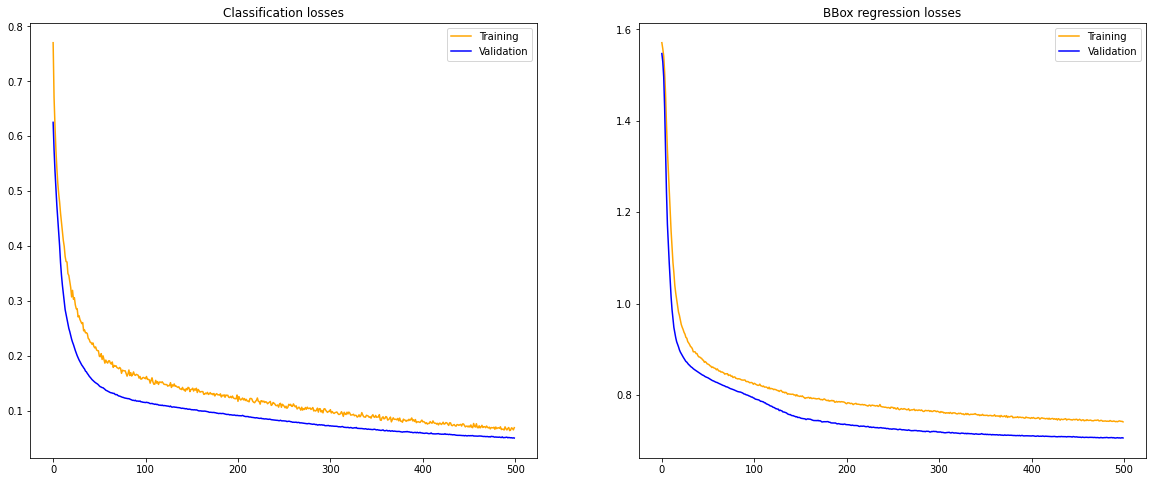

In [39]:
history = pnet.fit(train_images, y, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=pnet_callbacks)
print('[INFO] Training halted, plotting training history ... ')

history = history.history
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history['probability_loss'], color='orange', label='Training')
ax[0].plot(history['val_probability_loss'], color='blue', label='Validation')

ax[1].plot(history['bbox_regression_loss'], color='orange', label='Training')
ax[1].plot(history['val_bbox_regression_loss'], color='blue', label='Validation')

ax[0].legend()
ax[0].set_title('Classification losses')

ax[1].legend()
ax[1].set_title('BBox regression losses')

plt.savefig('PNet_training_result.png')
plt.show()

# Start training R-Net

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 
[INFO] 6220 negative samples generated ... 
[INFO] 4976 positive samples generated ... 
Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
functional_21 (Functional)      (None, None, None, 1 330         input_17[0][0]                   
__________________________________________________________________________________________________
functional_23 (Functional)      (None, None, None, 1 960         functional_21[0][0]              
______________________________________________________________________________________________

560/560 [==============================] - 2s 3ms/step - loss: 1.3393 - probability_loss: 0.3339 - bbox_regression_loss: 0.9957 - probability_accuracy: 0.8591 - val_loss: 1.1736 - val_probability_loss: 0.2572 - val_bbox_regression_loss: 0.9066 - val_probability_accuracy: 0.8978
Epoch 19/500
560/560 [==============================] - 2s 3ms/step - loss: 1.3417 - probability_loss: 0.3404 - bbox_regression_loss: 0.9915 - probability_accuracy: 0.8553 - val_loss: 1.1725 - val_probability_loss: 0.2558 - val_bbox_regression_loss: 0.9069 - val_probability_accuracy: 0.8973
Epoch 20/500
560/560 [==============================] - 2s 3ms/step - loss: 1.3282 - probability_loss: 0.3306 - bbox_regression_loss: 0.9879 - probability_accuracy: 0.8605 - val_loss: 1.1698 - val_probability_loss: 0.2534 - val_bbox_regression_loss: 0.9066 - val_probability_accuracy: 0.8978
Epoch 21/500
560/560 [==============================] - 2s 3ms/step - loss: 1.3243 - probability_loss: 0.3286 - bbox_regression_loss: 0.9

560/560 [==============================] - 2s 3ms/step - loss: 1.2178 - probability_loss: 0.2648 - bbox_regression_loss: 0.9432 - probability_accuracy: 0.8893 - val_loss: 1.1336 - val_probability_loss: 0.2177 - val_bbox_regression_loss: 0.9060 - val_probability_accuracy: 0.9161
Epoch 47/500
560/560 [==============================] - 2s 3ms/step - loss: 1.2132 - probability_loss: 0.2624 - bbox_regression_loss: 0.9409 - probability_accuracy: 0.8910 - val_loss: 1.1294 - val_probability_loss: 0.2139 - val_bbox_regression_loss: 0.9057 - val_probability_accuracy: 0.9165
Epoch 48/500
560/560 [==============================] - 2s 3ms/step - loss: 1.2102 - probability_loss: 0.2608 - bbox_regression_loss: 0.9396 - probability_accuracy: 0.8955 - val_loss: 1.1294 - val_probability_loss: 0.2144 - val_bbox_regression_loss: 0.9051 - val_probability_accuracy: 0.9170
Epoch 49/500
560/560 [==============================] - 2s 3ms/step - loss: 1.2200 - probability_loss: 0.2682 - bbox_regression_loss: 0.9

560/560 [==============================] - 2s 3ms/step - loss: 1.1598 - probability_loss: 0.2255 - bbox_regression_loss: 0.9244 - probability_accuracy: 0.9117 - val_loss: 1.0832 - val_probability_loss: 0.1818 - val_bbox_regression_loss: 0.8914 - val_probability_accuracy: 0.9312
Epoch 75/500
560/560 [==============================] - 2s 3ms/step - loss: 1.1569 - probability_loss: 0.2256 - bbox_regression_loss: 0.9213 - probability_accuracy: 0.9101 - val_loss: 1.0819 - val_probability_loss: 0.1802 - val_bbox_regression_loss: 0.8917 - val_probability_accuracy: 0.9317
Epoch 76/500
560/560 [==============================] - 2s 3ms/step - loss: 1.1640 - probability_loss: 0.2324 - bbox_regression_loss: 0.9217 - probability_accuracy: 0.9099 - val_loss: 1.0817 - val_probability_loss: 0.1807 - val_bbox_regression_loss: 0.8910 - val_probability_accuracy: 0.9312
Epoch 77/500
560/560 [==============================] - 2s 3ms/step - loss: 1.1555 - probability_loss: 0.2260 - bbox_regression_loss: 0.9

560/560 [==============================] - 2s 3ms/step - loss: 1.1152 - probability_loss: 0.1917 - bbox_regression_loss: 0.9135 - probability_accuracy: 0.9249 - val_loss: 1.0436 - val_probability_loss: 0.1497 - val_bbox_regression_loss: 0.8840 - val_probability_accuracy: 0.9433
Epoch 103/500
560/560 [==============================] - 2s 3ms/step - loss: 1.1115 - probability_loss: 0.1897 - bbox_regression_loss: 0.9118 - probability_accuracy: 0.9242 - val_loss: 1.0447 - val_probability_loss: 0.1507 - val_bbox_regression_loss: 0.8841 - val_probability_accuracy: 0.9424
Epoch 104/500
560/560 [==============================] - 2s 3ms/step - loss: 1.1178 - probability_loss: 0.1970 - bbox_regression_loss: 0.9109 - probability_accuracy: 0.9270 - val_loss: 1.0423 - val_probability_loss: 0.1487 - val_bbox_regression_loss: 0.8836 - val_probability_accuracy: 0.9455
Epoch 105/500
560/560 [==============================] - 2s 3ms/step - loss: 1.1119 - probability_loss: 0.1903 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 1.0795 - probability_loss: 0.1650 - bbox_regression_loss: 0.9044 - probability_accuracy: 0.9387 - val_loss: 1.0123 - val_probability_loss: 0.1246 - val_bbox_regression_loss: 0.8777 - val_probability_accuracy: 0.9509
Epoch 131/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0733 - probability_loss: 0.1585 - bbox_regression_loss: 0.9048 - probability_accuracy: 0.9400 - val_loss: 1.0127 - val_probability_loss: 0.1236 - val_bbox_regression_loss: 0.8790 - val_probability_accuracy: 0.9531
Epoch 132/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0725 - probability_loss: 0.1566 - bbox_regression_loss: 0.9059 - probability_accuracy: 0.9413 - val_loss: 1.0128 - val_probability_loss: 0.1237 - val_bbox_regression_loss: 0.8791 - val_probability_accuracy: 0.9513
Epoch 133/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0731 - probability_loss: 0.1603 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 1.0418 - probability_loss: 0.1343 - bbox_regression_loss: 0.8975 - probability_accuracy: 0.9490 - val_loss: 0.9919 - val_probability_loss: 0.1072 - val_bbox_regression_loss: 0.8747 - val_probability_accuracy: 0.9585
Epoch 159/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0498 - probability_loss: 0.1421 - bbox_regression_loss: 0.8977 - probability_accuracy: 0.9491 - val_loss: 0.9901 - val_probability_loss: 0.1058 - val_bbox_regression_loss: 0.8743 - val_probability_accuracy: 0.9598
Epoch 160/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0461 - probability_loss: 0.1374 - bbox_regression_loss: 0.8987 - probability_accuracy: 0.9504 - val_loss: 0.9870 - val_probability_loss: 0.1030 - val_bbox_regression_loss: 0.8739 - val_probability_accuracy: 0.9612
Epoch 161/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0442 - probability_loss: 0.1344 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 1.0196 - probability_loss: 0.1167 - bbox_regression_loss: 0.8929 - probability_accuracy: 0.9585 - val_loss: 0.9731 - val_probability_loss: 0.0916 - val_bbox_regression_loss: 0.8715 - val_probability_accuracy: 0.9647
Epoch 187/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0170 - probability_loss: 0.1143 - bbox_regression_loss: 0.8926 - probability_accuracy: 0.9579 - val_loss: 0.9758 - val_probability_loss: 0.0942 - val_bbox_regression_loss: 0.8717 - val_probability_accuracy: 0.9634
Epoch 188/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0204 - probability_loss: 0.1182 - bbox_regression_loss: 0.8922 - probability_accuracy: 0.9597 - val_loss: 0.9727 - val_probability_loss: 0.0911 - val_bbox_regression_loss: 0.8715 - val_probability_accuracy: 0.9647
Epoch 189/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0161 - probability_loss: 0.1145 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 1.0074 - probability_loss: 0.1088 - bbox_regression_loss: 0.8885 - probability_accuracy: 0.9614 - val_loss: 0.9621 - val_probability_loss: 0.0835 - val_bbox_regression_loss: 0.8685 - val_probability_accuracy: 0.9679
Epoch 215/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0098 - probability_loss: 0.1118 - bbox_regression_loss: 0.8880 - probability_accuracy: 0.9627 - val_loss: 0.9601 - val_probability_loss: 0.0827 - val_bbox_regression_loss: 0.8674 - val_probability_accuracy: 0.9679
Epoch 216/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0125 - probability_loss: 0.1131 - bbox_regression_loss: 0.8893 - probability_accuracy: 0.9615 - val_loss: 0.9636 - val_probability_loss: 0.0848 - val_bbox_regression_loss: 0.8688 - val_probability_accuracy: 0.9674
Epoch 217/500
560/560 [==============================] - 2s 3ms/step - loss: 1.0085 - probability_loss: 0.1099 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9985 - probability_loss: 0.1027 - bbox_regression_loss: 0.8857 - probability_accuracy: 0.9633 - val_loss: 0.9519 - val_probability_loss: 0.0768 - val_bbox_regression_loss: 0.8650 - val_probability_accuracy: 0.9692
Epoch 243/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9927 - probability_loss: 0.0969 - bbox_regression_loss: 0.8858 - probability_accuracy: 0.9666 - val_loss: 0.9532 - val_probability_loss: 0.0778 - val_bbox_regression_loss: 0.8654 - val_probability_accuracy: 0.9696
Epoch 244/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9928 - probability_loss: 0.0971 - bbox_regression_loss: 0.8857 - probability_accuracy: 0.9683 - val_loss: 0.9545 - val_probability_loss: 0.0782 - val_bbox_regression_loss: 0.8663 - val_probability_accuracy: 0.9688
Epoch 245/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9941 - probability_loss: 0.0992 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9844 - probability_loss: 0.0930 - bbox_regression_loss: 0.8813 - probability_accuracy: 0.9692 - val_loss: 0.9480 - val_probability_loss: 0.0754 - val_bbox_regression_loss: 0.8625 - val_probability_accuracy: 0.9710
Epoch 271/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9843 - probability_loss: 0.0933 - bbox_regression_loss: 0.8809 - probability_accuracy: 0.9667 - val_loss: 0.9461 - val_probability_loss: 0.0735 - val_bbox_regression_loss: 0.8626 - val_probability_accuracy: 0.9723
Epoch 272/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9782 - probability_loss: 0.0861 - bbox_regression_loss: 0.8820 - probability_accuracy: 0.9714 - val_loss: 0.9493 - val_probability_loss: 0.0769 - val_bbox_regression_loss: 0.8623 - val_probability_accuracy: 0.9701
Epoch 273/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9820 - probability_loss: 0.0907 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9687 - probability_loss: 0.0814 - bbox_regression_loss: 0.8772 - probability_accuracy: 0.9716 - val_loss: 0.9419 - val_probability_loss: 0.0718 - val_bbox_regression_loss: 0.8601 - val_probability_accuracy: 0.9732
Epoch 299/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9737 - probability_loss: 0.0849 - bbox_regression_loss: 0.8788 - probability_accuracy: 0.9731 - val_loss: 0.9416 - val_probability_loss: 0.0711 - val_bbox_regression_loss: 0.8604 - val_probability_accuracy: 0.9741
Epoch 300/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9716 - probability_loss: 0.0832 - bbox_regression_loss: 0.8783 - probability_accuracy: 0.9715 - val_loss: 0.9447 - val_probability_loss: 0.0745 - val_bbox_regression_loss: 0.8602 - val_probability_accuracy: 0.9719
Epoch 301/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9742 - probability_loss: 0.0871 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9666 - probability_loss: 0.0800 - bbox_regression_loss: 0.8766 - probability_accuracy: 0.9726 - val_loss: 0.9340 - val_probability_loss: 0.0680 - val_bbox_regression_loss: 0.8560 - val_probability_accuracy: 0.9746
Epoch 327/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9672 - probability_loss: 0.0812 - bbox_regression_loss: 0.8760 - probability_accuracy: 0.9736 - val_loss: 0.9366 - val_probability_loss: 0.0694 - val_bbox_regression_loss: 0.8571 - val_probability_accuracy: 0.9728
Epoch 328/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9602 - probability_loss: 0.0764 - bbox_regression_loss: 0.8738 - probability_accuracy: 0.9745 - val_loss: 0.9348 - val_probability_loss: 0.0677 - val_bbox_regression_loss: 0.8570 - val_probability_accuracy: 0.9732
Epoch 329/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9604 - probability_loss: 0.0767 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9616 - probability_loss: 0.0782 - bbox_regression_loss: 0.8734 - probability_accuracy: 0.9752 - val_loss: 0.9314 - val_probability_loss: 0.0675 - val_bbox_regression_loss: 0.8539 - val_probability_accuracy: 0.9746
Epoch 355/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9621 - probability_loss: 0.0786 - bbox_regression_loss: 0.8734 - probability_accuracy: 0.9724 - val_loss: 0.9300 - val_probability_loss: 0.0652 - val_bbox_regression_loss: 0.8547 - val_probability_accuracy: 0.9746
Epoch 356/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9565 - probability_loss: 0.0746 - bbox_regression_loss: 0.8719 - probability_accuracy: 0.9749 - val_loss: 0.9289 - val_probability_loss: 0.0646 - val_bbox_regression_loss: 0.8543 - val_probability_accuracy: 0.9746
Epoch 357/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9594 - probability_loss: 0.0759 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9479 - probability_loss: 0.0693 - bbox_regression_loss: 0.8685 - probability_accuracy: 0.9754 - val_loss: 0.9303 - val_probability_loss: 0.0677 - val_bbox_regression_loss: 0.8526 - val_probability_accuracy: 0.9763
Epoch 383/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9444 - probability_loss: 0.0644 - bbox_regression_loss: 0.8700 - probability_accuracy: 0.9792 - val_loss: 0.9292 - val_probability_loss: 0.0669 - val_bbox_regression_loss: 0.8523 - val_probability_accuracy: 0.9763
Epoch 384/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9468 - probability_loss: 0.0666 - bbox_regression_loss: 0.8701 - probability_accuracy: 0.9803 - val_loss: 0.9271 - val_probability_loss: 0.0647 - val_bbox_regression_loss: 0.8523 - val_probability_accuracy: 0.9754
Epoch 385/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9500 - probability_loss: 0.0694 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9488 - probability_loss: 0.0710 - bbox_regression_loss: 0.8677 - probability_accuracy: 0.9753 - val_loss: 0.9209 - val_probability_loss: 0.0614 - val_bbox_regression_loss: 0.8495 - val_probability_accuracy: 0.9768
Epoch 411/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9429 - probability_loss: 0.0649 - bbox_regression_loss: 0.8679 - probability_accuracy: 0.9785 - val_loss: 0.9222 - val_probability_loss: 0.0619 - val_bbox_regression_loss: 0.8502 - val_probability_accuracy: 0.9759
Epoch 412/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9472 - probability_loss: 0.0688 - bbox_regression_loss: 0.8684 - probability_accuracy: 0.9782 - val_loss: 0.9227 - val_probability_loss: 0.0631 - val_bbox_regression_loss: 0.8495 - val_probability_accuracy: 0.9763
Epoch 413/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9430 - probability_loss: 0.0656 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9412 - probability_loss: 0.0648 - bbox_regression_loss: 0.8663 - probability_accuracy: 0.9780 - val_loss: 0.9234 - val_probability_loss: 0.0647 - val_bbox_regression_loss: 0.8487 - val_probability_accuracy: 0.9763
Epoch 439/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9346 - probability_loss: 0.0602 - bbox_regression_loss: 0.8644 - probability_accuracy: 0.9809 - val_loss: 0.9180 - val_probability_loss: 0.0603 - val_bbox_regression_loss: 0.8477 - val_probability_accuracy: 0.9772
Epoch 440/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9381 - probability_loss: 0.0632 - bbox_regression_loss: 0.8649 - probability_accuracy: 0.9779 - val_loss: 0.9179 - val_probability_loss: 0.0602 - val_bbox_regression_loss: 0.8477 - val_probability_accuracy: 0.9781
Epoch 441/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9453 - probability_loss: 0.0694 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9281 - probability_loss: 0.0555 - bbox_regression_loss: 0.8626 - probability_accuracy: 0.9819 - val_loss: 0.9182 - val_probability_loss: 0.0627 - val_bbox_regression_loss: 0.8455 - val_probability_accuracy: 0.9777
Epoch 467/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9324 - probability_loss: 0.0591 - bbox_regression_loss: 0.8633 - probability_accuracy: 0.9810 - val_loss: 0.9160 - val_probability_loss: 0.0596 - val_bbox_regression_loss: 0.8465 - val_probability_accuracy: 0.9786
Epoch 468/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9332 - probability_loss: 0.0608 - bbox_regression_loss: 0.8625 - probability_accuracy: 0.9793 - val_loss: 0.9173 - val_probability_loss: 0.0616 - val_bbox_regression_loss: 0.8457 - val_probability_accuracy: 0.9768
Epoch 469/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9358 - probability_loss: 0.0621 - bbox_regression_loss: 

560/560 [==============================] - 2s 3ms/step - loss: 0.9311 - probability_loss: 0.0590 - bbox_regression_loss: 0.8620 - probability_accuracy: 0.9812 - val_loss: 0.9143 - val_probability_loss: 0.0593 - val_bbox_regression_loss: 0.8450 - val_probability_accuracy: 0.9786
Epoch 495/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9304 - probability_loss: 0.0592 - bbox_regression_loss: 0.8612 - probability_accuracy: 0.9820 - val_loss: 0.9129 - val_probability_loss: 0.0582 - val_bbox_regression_loss: 0.8448 - val_probability_accuracy: 0.9790
Epoch 496/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9261 - probability_loss: 0.0549 - bbox_regression_loss: 0.8612 - probability_accuracy: 0.9817 - val_loss: 0.9160 - val_probability_loss: 0.0607 - val_bbox_regression_loss: 0.8453 - val_probability_accuracy: 0.9786
Epoch 497/500
560/560 [==============================] - 2s 3ms/step - loss: 0.9332 - probability_loss: 0.0617 - bbox_regression_loss: 

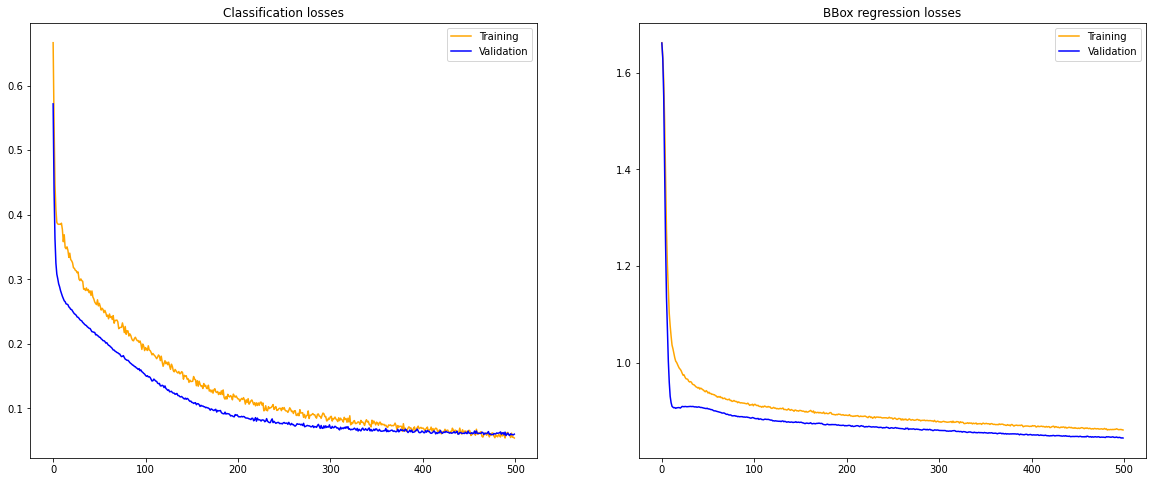

In [40]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, frame_per_img=5, crop_size=(input_dim*2,input_dim*2))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(10, 30), frame_per_img=4, img_size=input_dim*2)
pos_samples[:, 2] = 1.0
# pos_samples[:,2] = LabelEncoder().fit_transform(pos_samples[:, 2])
# pos_samples[:,2] += 1

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() 
    # 'bbox_regression' : MeanSquaredError(reduction=tf.keras.losses.Reduction.AUTO)
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

rnet = build_pnet_model(input_shape=input_dim*2, batch_norm=True, dropout=True, n_classes=n_classes)
print(rnet.summary())

if(os.path.exists(rnet_weights)):
    print('[INFO] Loading R-Net pretrained weights ...')
    rnet.load_weights(rnet_weights)

rnet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

history = rnet.fit(train_images, y, epochs=epochs, batch_size=batch_size, callbacks=rnet_callbacks, validation_split=0.2)
print('[INFO] Training halted, plotting training history ... ')

history = history.history
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history['probability_loss'], color='orange', label='Training')
ax[0].plot(history['val_probability_loss'], color='blue', label='Validation')
""
ax[1].plot(history['bbox_regression_loss'], color='orange', label='Training')
ax[1].plot(history['val_bbox_regression_loss'], color='blue', label='Validation')

ax[0].legend()
ax[0].set_title('Classification losses')

ax[1].legend()
ax[1].set_title('BBox regression losses')

plt.savefig('RNet_training_result.png')
plt.show()

# Training O-Net

[INFO] From images to ground truth ... 
[INFO] Converting to raw dataset ... 
[INFO] 1244 samples loaded ... 
[INFO] 4976 negative samples generated ... 


<ipython-input-3-223f64bb23c3>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(neg_samples)
<ipython-input-4-280b28c2d059>:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(pos_samples)


[INFO] 4976 positive samples generated ... 
Model: "P-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
model_7 (Functional)            (None, None, None, 1 330         input_12[0][0]                   
__________________________________________________________________________________________________
model_8 (Functional)            (None, None, None, 1 960         model_7[0][0]                    
__________________________________________________________________________________________________
model_9 (Functional)            (None, None, None, 1 960         model_8[0][0]                    
__________________________________________________

498/498 [==============================] - 7s 13ms/step - loss: 1.2790 - probability_loss: 0.3252 - bbox_regression_loss: 0.9421 - probability_accuracy: 0.8608 - val_loss: 1.1759 - val_probability_loss: 0.2648 - val_bbox_regression_loss: 0.8994 - val_probability_accuracy: 0.8825
Epoch 48/100
498/498 [==============================] - 7s 14ms/step - loss: 1.2842 - probability_loss: 0.3310 - bbox_regression_loss: 0.9415 - probability_accuracy: 0.8525 - val_loss: 1.1740 - val_probability_loss: 0.2636 - val_bbox_regression_loss: 0.8987 - val_probability_accuracy: 0.8830
Epoch 49/100
498/498 [==============================] - 7s 14ms/step - loss: 1.2851 - probability_loss: 0.3348 - bbox_regression_loss: 0.9386 - probability_accuracy: 0.8583 - val_loss: 1.1723 - val_probability_loss: 0.2622 - val_bbox_regression_loss: 0.8983 - val_probability_accuracy: 0.8830
Epoch 50/100
498/498 [==============================] - 7s 14ms/step - loss: 1.2702 - probability_loss: 0.3159 - bbox_regression_loss:

498/498 [==============================] - 7s 15ms/step - loss: 1.2126 - probability_loss: 0.2756 - bbox_regression_loss: 0.9252 - probability_accuracy: 0.8800 - val_loss: 1.1315 - val_probability_loss: 0.2275 - val_bbox_regression_loss: 0.8923 - val_probability_accuracy: 0.9071
Epoch 76/100
498/498 [==============================] - 7s 15ms/step - loss: 1.2197 - probability_loss: 0.2811 - bbox_regression_loss: 0.9268 - probability_accuracy: 0.8830 - val_loss: 1.1294 - val_probability_loss: 0.2261 - val_bbox_regression_loss: 0.8916 - val_probability_accuracy: 0.9091
Epoch 77/100
498/498 [==============================] - 7s 15ms/step - loss: 1.2058 - probability_loss: 0.2695 - bbox_regression_loss: 0.9245 - probability_accuracy: 0.8893 - val_loss: 1.1284 - val_probability_loss: 0.2255 - val_bbox_regression_loss: 0.8911 - val_probability_accuracy: 0.9106
Epoch 78/100
498/498 [==============================] - 7s 15ms/step - loss: 1.2129 - probability_loss: 0.2744 - bbox_regression_loss:

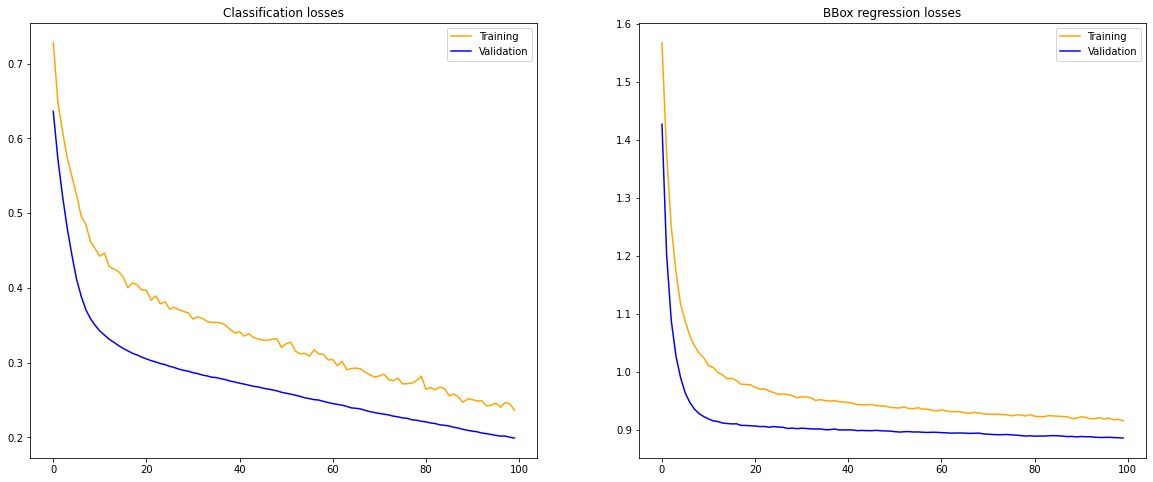

In [15]:
# Generate raw data from firectory
raw_dataset = load_raw_dataset(train_dir, 'gt.txt')
neg_samples = generate_neg_samples(raw_dataset, frame_per_img=4, crop_size=(input_dim*4,input_dim*4))
pos_samples = generate_pos_samples(raw_dataset, pad_range=(10, 30), frame_per_img=4, img_size=input_dim*4)
pos_samples[:, 2] = 1.0

# Concatenate two groups and shuffle
train_dataset = np.concatenate([pos_samples, neg_samples])
np.random.shuffle(train_dataset)

train_images = np.array([x[0] for x in train_dataset])
train_bboxes = np.array([x[1] for x in train_dataset])
train_labels = OneHotEncoder().fit_transform(train_dataset[:,2].reshape(-1, 1)).toarray()

train_bboxes = train_bboxes.reshape(-1, 1, 1, 4)
train_labels = train_labels.reshape(-1, 1, 1, train_labels.shape[1])

train_images = ((train_images - 127.5) / 127.5).astype('float32')
train_bboxes = train_bboxes.astype('float32')
train_labels = train_labels.astype('float32')

losses = {
    'probability' : BinaryCrossentropy(from_logits=False),
    'bbox_regression' : tfa.losses.GIoULoss() 
}

y = {
    'probability' : train_labels,
    'bbox_regression' : train_bboxes
}

onet = build_pnet_model(input_shape=input_dim*4, batch_norm=True, dropout=True, n_classes=n_classes)
print(onet.summary())

if(os.path.exists(onet_weights)):
    print('[INFO] Loading O-Net pretrained weights ...')
    onet.load_weights(onet_weights)
onet.compile(optimizer=Adam(lr=0.00001, amsgrad=True),
            loss=losses,
            metrics={'probability':'accuracy'})

history = onet.fit(train_images, y, epochs=epochs, validation_split=0.2, batch_size=batch_size, callbacks=onet_callbacks)
print('[INFO] Training halted, plotting training history ... ')

history = history.history
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history['probability_loss'], color='orange', label='Training')
ax[0].plot(history['val_probability_loss'], color='blue', label='Validation')
""
ax[1].plot(history['bbox_regression_loss'], color='orange', label='Training')
ax[1].plot(history['val_bbox_regression_loss'], color='blue', label='Validation')

ax[0].legend()
ax[0].set_title('Classification losses')

ax[1].legend()
ax[1].set_title('BBox regression losses')

plt.savefig('ONet_training_result.png')
plt.show()

# Test P-Net proposals

In [41]:
pnet = build_pnet_model(input_shape=input_dim, batch_norm=True, dropout=True, n_classes=n_classes)
rnet = build_pnet_model(input_shape=input_dim*2, batch_norm=True, dropout=True, n_classes=n_classes)
onet = build_pnet_model(input_shape=input_dim*4, batch_norm=True, dropout=True, n_classes=n_classes)


if(os.path.exists(pnet_weights)):
    print('[INFO] Loading weights for P-Net ... ')
    pnet.load_weights(pnet_weights)

if(os.path.exists(rnet_weights)):
    print('[INFO] Loading weights for R-Net ... ')
    rnet.load_weights(rnet_weights)

if(os.path.exists(onet_weights)):
    print('[INFO] Loading weights for o-Net ... ')
    onet.load_weights(onet_weights)
    
def __nms(boxes, s, threshold, method):
    """
        Non Maximum Suppression.

        Params:
            @param boxes: np array with bounding boxes.
            @param threshold:
            @param method: NMS method to apply. Available values ('Min', 'Union')
        
        Return:
            pick : An array of indices selected.
    """
    if boxes.size == 0:
        return np.empty((0, 3))

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2] + x1
    y2 = boxes[:, 3] + y1

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    sorted_s = np.argsort(s)

    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while sorted_s.size > 0:
        i = sorted_s[-1]
        pick[counter] = i
        counter += 1
        idx = sorted_s[0:-1]

        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)

        inter = w * h

        if method == 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)

        sorted_s = sorted_s[np.where(o <= threshold)]

    pick = pick[0:counter]

    return pick

[INFO] Loading weights for P-Net ... 
[INFO] Loading weights for R-Net ... 


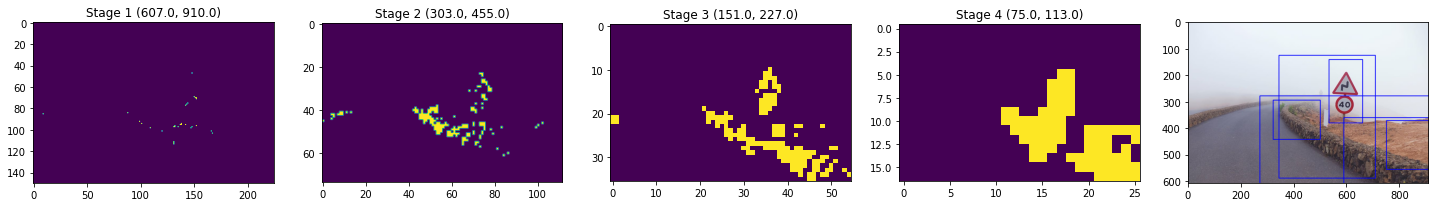

In [58]:
# raw_img = cv2.imread(os.path.join(train_dir, 'road155.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road198.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road202.png')) # --> True but quite abit of overlapping boxes
# raw_img = cv2.imread(os.path.join(train_dir, 'road215.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road797.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road655.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road420.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road123.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road109.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road108.png')) # --> False, target too small
# raw_img = cv2.imread(os.path.join(train_dir, 'road99.png')) # --> Very true
# raw_img = cv2.imread(os.path.join(train_dir, 'road90.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road282.png')) # --> False, too blurry
# raw_img = cv2.imread(os.path.join(train_dir, 'road282.png')) # --> False, too blurry
# raw_img = cv2.imread(os.path.join(train_dir, 'road147.png')) # --> True
# raw_img = cv2.imread(os.path.join(train_dir, 'road585.png'))
# raw_img = cv2.imread(os.path.join(train_dir, 'road595.png'))
raw_img = cv2.imread('test/test4.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)

def get_bboxes_pnet(raw_img, threshold=0.7, nms_threshold=0.5,
                    scale_factor=2.0, min_img_size = 48, padding = 0.15, visualize=False):
    '''
        
    '''
    H, W = raw_img.shape[:2]
    images = [raw_img]
    current_h, current_w = raw_img.shape[:2]
    
    ### 1. Get image pyramid ###
    while(current_h > min_img_size and current_w > min_img_size):
        current_h = int(current_h / scale_factor)
        current_w = int(current_w / scale_factor)

        if(current_w < min_img_size or current_h < min_img_size) : break

        image = cv2.resize(raw_img, (current_w, current_h))
        images.append(image)

    ### 2. Get bounding boxes from each image in the pyramid ###
    boxes = []
    conf_maps_viz = []
    for i, image in enumerate(images):
        if(i == 0): scale = 1
        else : scale = scale_factor ** i

        img = (image - 127.5) / 127.5
        height, width = image.shape[:2]

        predictions = pnet.predict(np.array([img]))
        features_shape = predictions[1][0].shape[:2]

        scale_w = width / features_shape[1]
        scale_h = height / features_shape[0]

        bboxes = predictions[1][0]
        raw_bboxes = bboxes
        confidence = predictions[0][0]

        ### Getting confidence map ###
        conf_map = confidence[:, :, 1]
        conf_map[conf_map > threshold] = 1.0
        conf_map[conf_map <= threshold] = 0
        conf_map = (conf_map * 255).astype(np.uint8)
        contours, hierarchy = cv2.findContours(conf_map, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        conf_maps_viz.append(conf_map)
        
        for contour in contours:
            rect = cv2.boundingRect(contour)
            x, y, w, h = (rect * np.array([W/conf_map.shape[1],H/conf_map.shape[0],W/conf_map.shape[1],H/conf_map.shape[0] ])).astype(int)

            x -= min(int(padding * w), x)
            y -= min(int(padding * h), y)
            w += 2*int(padding * w)
            h += 2*int(padding * h)
            if(w * h < (W * H)/64): continue
            boxes.append([x,y,w,h])
    
    ### Performing nms ###
    final_boxes = []
    pick = __nms(np.array(boxes), np.ones((len(boxes))), nms_threshold, 'Min')
    for i in range(len(boxes)):
        final_boxes.append(boxes[i])
        
    crops = []
    if(visualize):
        fig, ax = plt.subplots(1, len(conf_maps_viz) + 1, figsize=(5*(len(conf_maps_viz) + 1), 5))
        for i in range(len(conf_maps_viz)):
            current_size = (H // (scale_factor ** i),W // (scale_factor**i))
            ax[i].imshow(conf_maps_viz[i])
            ax[i].set_title(f'Stage {i+1} {current_size}')
        
    raw_img_copy = raw_img.copy()
    for (x, y, w, h) in final_boxes:
        cv2.rectangle(raw_img_copy, (x,y), (x+w, y+h), (0,0,255),2)
        crops.append([(x,y,w,h), raw_img[y:y+h, x:x+w]])
            
    if(visualize):
        plt.imshow(raw_img_copy)
        plt.show()
        
    return final_boxes, crops
        
boxes, crops = get_bboxes_pnet(raw_img, visualize=True)

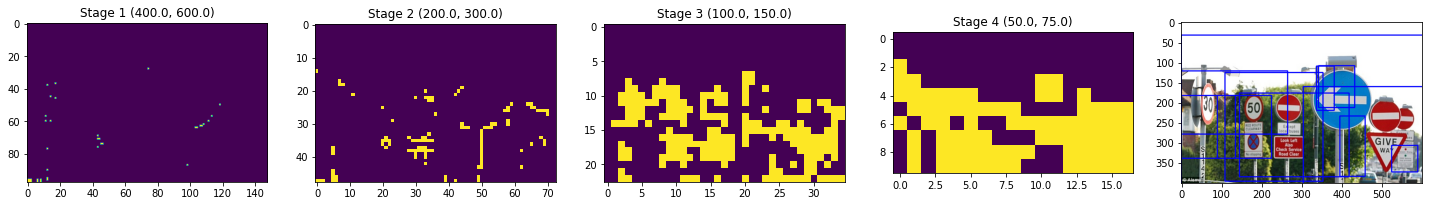

FPS : 58.67487365226968


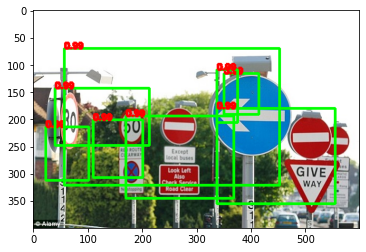

In [61]:
raw_img = cv2.imread('test/test.jpg')
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
boxes, crops = get_bboxes_pnet(raw_img, visualize=True)

raw_img_copy = raw_img.copy()
boxes = []

n_frames = 0
start = time.time()
for i in crops:
    n_frames += 1
    crop = i[1]
    (x, y, w, h) = i[0]
    H, W = crop.shape[:2]
    img = cv2.resize(crop, (input_dim*2, input_dim*2))
    img = (img - 127.5) / 127.5
    
    prediction = rnet.predict(np.array([img]))
    confidence = prediction[0][0][0][0]
    
    label = np.argmax(confidence)
    confidence = confidence[np.argmax(confidence)]
    
    bbox = prediction[1][0][0][0]
    if(confidence < 0.8 or label == 0):continue
    
    x_,y_,w,h = (bbox * np.array([W, H, W, H])).astype('int')
    x+=x_
    y+=y_
    
    boxes.append([x, y, w, h])
end = time.time()
print(f'FPS : {n_frames/(end - start)}')

pick = __nms(np.array(boxes), np.ones((len(boxes))), 0.3, 'Max')
for i in pick:
    x, y, w, h = boxes[i]
    raw_img_copy = cv2.rectangle(raw_img_copy, (x, y), (x+w, y+h), (0,255,0), 3)
    raw_img_copy = cv2.putText(raw_img_copy, f'{confidence:.2f}', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 3)
    
plt.imshow(raw_img_copy)
plt.show()